In [118]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from pmdarima import auto_arima
import warnings


In [172]:
#Aquiring stock data of Apple
tickerSymbol = 'AAPl'   #EMG.L
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(interval='1d',start='2017-4-1',end='2022-6-1',)
tickerDf.index = tickerDf.index.tz_localize(None)
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03,33.768534,33.864872,33.613448,33.766182,79942800,0.0,0.0
2017-04-04,33.660454,34.045816,33.641655,34.017620,79565600,0.0,0.0
2017-04-05,33.888380,34.179752,33.792038,33.841385,110871600,0.0,0.0
2017-04-06,33.904827,33.958874,33.707447,33.756794,84596000,0.0,0.0
2017-04-07,33.773228,33.878967,33.665141,33.681587,66688800,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-24,140.381810,141.538287,136.912397,139.933182,104132700,0.0,0.0
2022-05-25,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0
2022-05-26,136.972206,143.901068,136.722966,143.342773,90601500,0.0,0.0


In [183]:
#Aquiring Discount rates from federal reserve interest rate data + initial cleaning
frData=pd.read_csv('src/FRB_H15.csv')
frData.columns = ['Date','Federal funds Rate','Prime Rate','Discount Rate']
frData = frData[5:]
frData = frData.reset_index(drop=True)
frData = frData.set_index('Date')

# seperating the discount rate data , converting date to datetime and values to float
discountRate = pd.DataFrame(frData['Discount Rate'])
discountRate.index = pd.to_datetime(discountRate.index)
discountRate = discountRate.astype({'Discount Rate': 'float'})
discountRate

,Discount Rate
Date,
2016-08-03,1.00
2016-08-10,1.00
2016-08-17,1.00
2016-08-24,1.00
2016-08-31,1.00
...,...
2022-06-29,1.75
2022-07-06,1.75
2022-07-13,1.75


In [184]:
# resampling data and interpolating missing values using pad and setting type as float
discountRate = pd.DataFrame(discountRate.resample('1d').sum())
discountRate[discountRate == 0] = None
discountRate = discountRate.interpolate(method='pad')
discountRate

,Discount Rate
Date,
2016-08-03,1.00
2016-08-04,1.00
2016-08-05,1.00
2016-08-06,1.00
2016-08-07,1.00
...,...
2022-07-23,1.75
2022-07-24,1.75
2022-07-25,1.75


In [160]:
tickerDfResample = pd.DataFrame(tickerDf.resample('1d').sum())
tickerDfResample[tickerDfResample == 0] = None
tickerDfResample = tickerDfResample.interpolate(method='pad')
tickerDfResample = np.log(tickerDfResample)
tickerDfResample

first_diff = tickerDfResample.Close.values[1:]-tickerDfResample.Close.values[:-1]
first_diff = np.concatenate([first_diff,[0]])
tickerDfResample['FirstDifference'] = first_diff
tickerDfResample['PercentageChange'] = tickerDfResample.Close.pct_change().fillna(0) #  "by what percentage did previous value change to get to current value"current value - previous value / previous value = pct change
tickerDfResample

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference,PercentageChange
Date,,,,,,,,,
2017-04-03,3.519529,3.522378,3.514926,3.519460,18.196822,NaN,NaN,0.007419,0.000000
2017-04-04,3.516323,3.527707,3.515765,3.526878,18.192092,NaN,NaN,-0.005194,0.002108
2017-04-05,3.523072,3.531633,3.520225,3.521684,18.523883,NaN,NaN,-0.002503,-0.001473
2017-04-06,3.523557,3.525150,3.517718,3.519181,18.253398,NaN,NaN,-0.002230,-0.000711
2017-04-07,3.519669,3.522794,3.516463,3.516951,18.015548,NaN,NaN,0.000000,-0.000634
...,...,...,...,...,...,...,...,...,...
2022-05-27,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.008046
2022-05-28,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.000000
2022-05-29,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.000000


In [161]:
tickerDfResample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1885 entries, 2017-04-03 to 2022-05-31
Freq: D
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1885 non-null   float64
 1   High              1885 non-null   float64
 2   Low               1885 non-null   float64
 3   Close             1885 non-null   float64
 4   Volume            1885 non-null   float64
 5   Dividends         1847 non-null   float64
 6   Stock Splits      639 non-null    float64
 7   FirstDifference   1885 non-null   float64
 8   PercentageChange  1885 non-null   float64
dtypes: float64(9)
memory usage: 147.3 KB


In [162]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. ADF: ",dftest[0])
    print("2. P_value: ",dftest[1])
    print("3. num_lags: ",dftest[2])
    print("4. : ",dftest[3])
    print("5. crit_value: ",dftest[4])
    for key,val in dftest[4].items():
        print("\t",key,": ",val)
        
ad_test(tickerDfResample['Close'])

1. ADF:  -0.6590411759916867
2. P_value:  0.8570755309173893
3. num_lags:  13
4. :  1871
5. crit_value:  {'1%': -3.433849890092939, '5%': -2.863086004488984, '10%': -2.567593036523882}
	 1% :  -3.433849890092939
	 5% :  -2.863086004488984
	 10% :  -2.567593036523882


In [119]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(tickerDfResample['Close'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10141.491, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10126.275, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10146.911, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10147.333, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10123.981, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10145.318, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10145.327, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10143.356, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10143.854, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.233 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5076.666
Date:                Tue, 24 Jan 2023   AIC                         -10147.333
Time:                        19:31:18   BIC                         -10130.709
Sample:                    04-03-2017   HQIC                        -10141.210
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      2.288      0.022       0.000       0.001
ma.L1         -0.1110      0.015     -7.294      0.000      -0.141      -0.081
sigma2         0.0003    3.7e-06     72.150      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7190.52
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

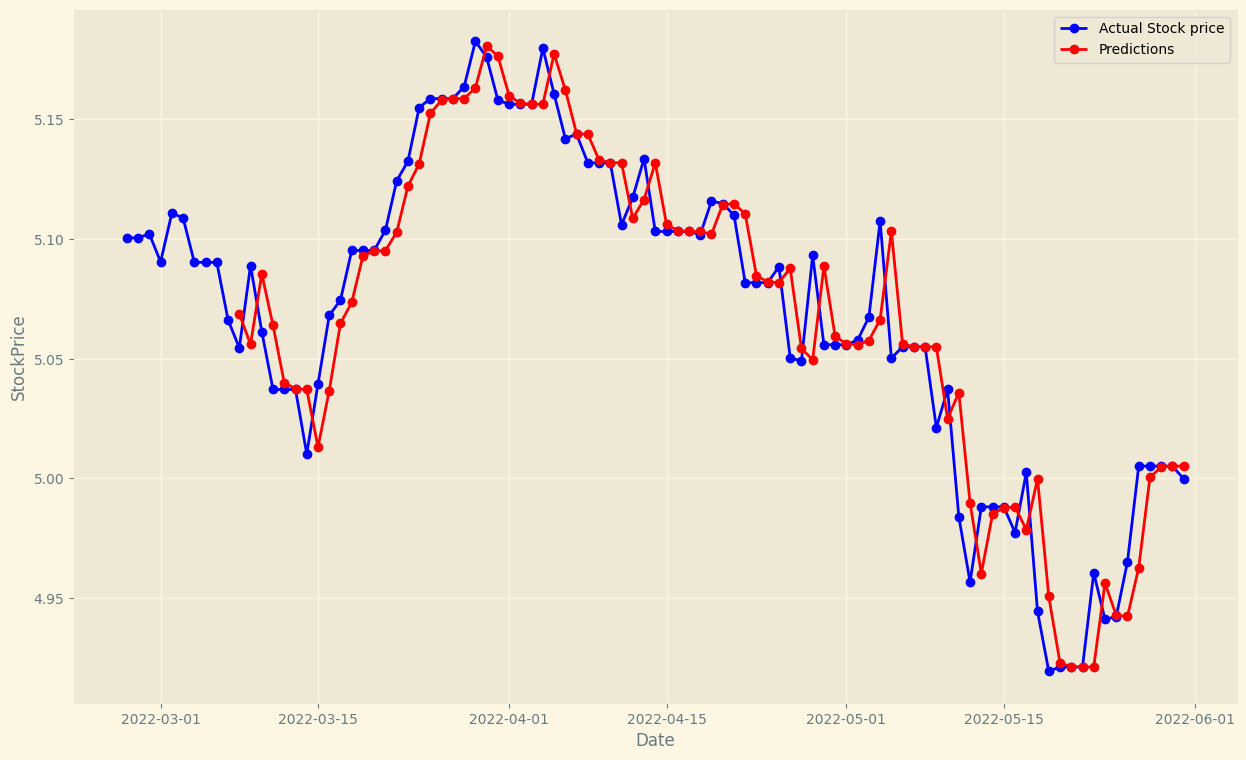

In [163]:
#close price prediction
trainData = tickerDfResample['Close'][0:1800]
testData = pd.DataFrame(tickerDfResample['Close'][1800:])
testData['Predictions'] = 0 
for i in range(len(testData)):
    model = ARIMA(trainData,order=(0,1,1))
    modelFit = model.fit()
   
    futureForcast = modelFit.forecast(20)
    futureForcast = np.mean(futureForcast)
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    
   
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show() 

In [164]:
#Fbprophet prediction
df = pd.DataFrame(tickerDfResample['Close'][0:1250]).reset_index()
df.columns = ['ds','y']
df['ds'] = df['ds'].dt.tz_localize(None)
testData = pd.DataFrame(tickerDfResample['Close'][1250:])

model = Prophet()
model.fit(df)

19:51:06 - cmdstanpy - INFO - Chain [1] start processing
19:51:07 - cmdstanpy - INFO - Chain [1] done processing


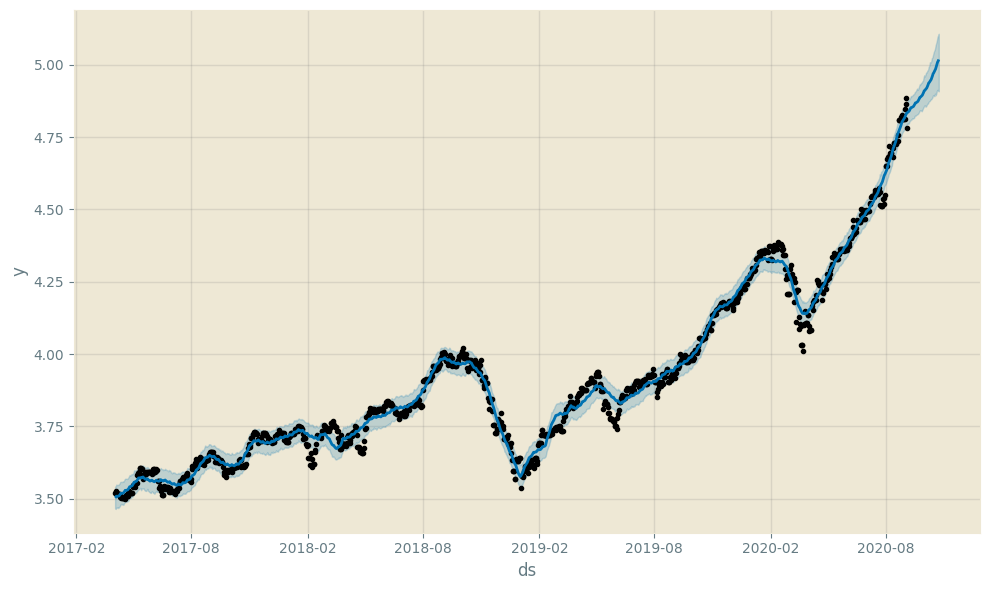

In [165]:
futureDates = model.make_future_dataframe(periods = 50)
prediction = model.predict(futureDates)
fig = model.plot(prediction)